# A model of investor sentiment

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [65]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Model setup**

The purpose of this model is to understand how a representative rational investor operates on the stock market, given a wrong idea of the true model of the assets.

_**True model of dividend earnings**_

Earnings at time $t$: $N_t = N_{t-1}+y_t\\$ 
Where $y_t$ is a random shock to earnings that can take two values, $y$ and $-y$ with equal probability


_**The mode investor believes**_

Investor believes the shocks in two consecutive periods to be correlated.\
The correlation can be negative (Mean reversion) or positive (momentum)\
The two models can be described by:

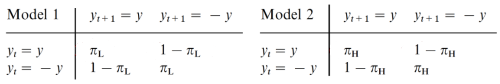

Assume $\pi_L < \frac{1}{2} < \pi_H$

Such that if investor believes in model 1, a positive shock in $y_{t+1}$ is less likely after a positive shock in $y$\
If investor believes in model 2, a positive shock in $y_{t+1}$ is more likely after a positive shock in $y$

If investor believes in model 1, he reacts too little to individual earnings announcements that creates a positive shock, as he expects a negative shock in the following period.\
Conversely, if he believes in model 2, he reacts too strongly in strings of positive shocks, as he expects the positive shocks to continue.

_Model switching_

Investor believes in two states of the world:\
$s_t = 1$: Earnings shock in $y_t$ is generated by model 1\
$s_t = 2$: Earnings shock in $y_t$ is generated by model 2\

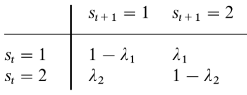

Assume $\lambda_1+\lambda_2 < 1$ (regime switch is rare)

_**Investor's earnings forecast**_

Investor observes earnings in each period and tries to understand which model is currently governing earnings.\
In the following, investor observes $y_{t+1}$ and calculates the probability $q_{t+1}$ = probability that model 1 generated the earnings.\
$q_{t+1}=P(s_{t+1}=1 | y_{t+1},y_t,q_t)$

$q_{t+1}=\frac{P(y_{t+1}|y_t,s_{t+1}=1)*P(s_{t+1}=1)}{P(y_{t+1}|y_t,s_{t+1}=1)*P(s_{t+1}=1)+P(y_{t+1}|y_t,s_{t+1}=2)*P(s_{t+1}=2)}$

Where:\
$P(s_{t+1}=1)=(1-\lambda_1)q_t + \lambda_2(1-q_t)$\
$P(s_{t+1}=2)=\lambda_1q_t + (1-\lambda_2)(1-q_t)$


_Shocks with same sign in t and t+1_\
$P(y_{t+1}=y|y_t=y,s_{t+1}=1)=P(y_{t+1}=-y|y_t=-y,s_{t+1}=1)=\pi_L$\
$P(y_{t+1}=y|y_t=y,s_{t+1}=2)=P(y_{t+1}=-y|y_t=-y,s_{t+1}=2)=\pi_H$

$q_{t+1}=\frac{\pi_L[(1-\lambda_1)q_t+\lambda_2(1-q_t)]}{\pi_L[(1-\lambda_1)q_t+\lambda_2(1-q_t)]+\pi_H[\lambda_1q_t+(1-\lambda_2)(1-q_t)]}$
\
\
\
\
_Shocks with opposite sign in t and t+1_\
$P(y_{t+1}=y|y_t=-y,s_{t+1}=1)=P(y_{t+1}=-y|y_t=y,s_{t+1}=1)=1-\pi_L$\
$P(y_{t+1}=y|y_t=-y,s_{t+1}=2)=P(y_{t+1}=-y|y_t=y,s_{t+1}=2)=1-\pi_H$

$q_{t+1}=\frac{(1-\pi_L)[(1-\lambda_1)q_t+\lambda_2(1-q_t)]}{(1-\pi_L)[(1-\lambda_1)q_t+\lambda_2(1-q_t)]+(1-\pi_H)[\lambda_1q_t+(1-\lambda_2)(1-q_t)]}$

## Numerical solution

In [83]:
from modelproject import InvestorForecast
model = InvestorForecast()
par = model.par

Initial parameters are defined in the .py file

**Investor's forecast**

_Proof of concept_

In [92]:
print(f'Probability that model 1 governs earnings in period t+1 when two identical shocks hit: {model.forecast(1,1,par.q_ini):.2f}')
print(f'Probability that model 1 governs earnings in period t+1 when two oppostite shocks hit: {model.forecast(1,-1,par.q_ini):.2f}')

Probability that model 1 governs earnings in period t+1 when two identical shocks hit: 0.40
Probability that model 1 governs earnings in period t+1 when two oppostite shocks hit: 0.60


The investor's perceived probability that model 1 governs earnings increases as shocks changes signs

**Convergence given consecutive shocks with same sign**

In the following, $q_{t+1}$ will be saved as _q_ for the consecutive period.

Iteration	q		new_q
1		0.500000	0.400000
2		0.400000	0.380952
3		0.380952	0.377358
4		0.377358	0.376682
5		0.376682	0.376554
6		0.376554	0.376530
7		0.376530	0.376526
8		0.376526	0.376525


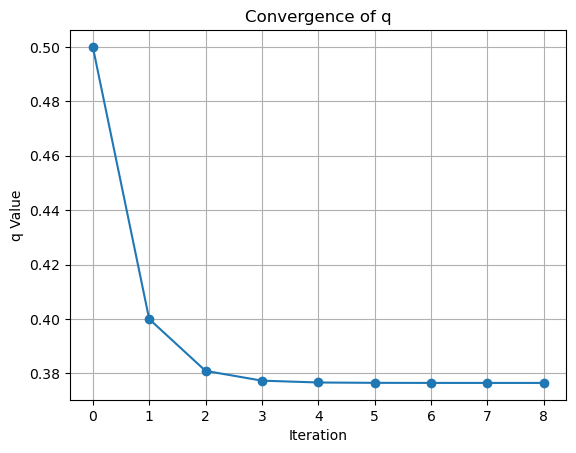

In [93]:
model.convergence(1,1)

Given the initial parameters and consecutive positive shocks to $y_t$, investor will believe model 1 governs earnings at probability 0.38

**Convergence given consecutive shocks with different signs**

Iteration	q		new_q
1		0.500000	0.600000
2		0.600000	0.619048
3		0.619048	0.622642
4		0.622642	0.623318
5		0.623318	0.623446
6		0.623446	0.623470
7		0.623470	0.623474
8		0.623474	0.623475


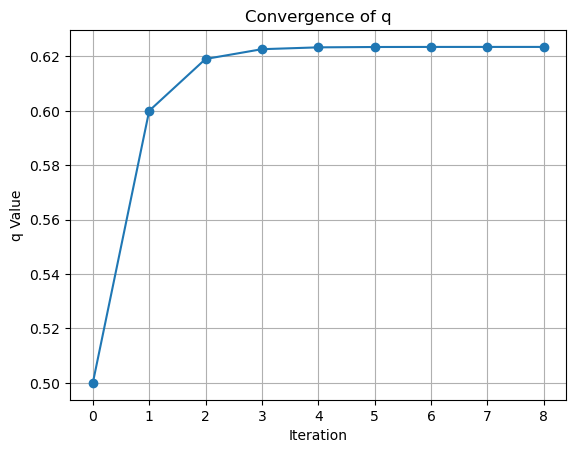

In [94]:
model.convergence(1,-1)

Given the initial parameters and consecutive alternating shocks to $y_t$, investor will believe model 1 governs earnings at probability 0.62

**Plot of the first 20 periods with randomly distributed shocks**

Iteration  1: old_y =  1, new_y = -1, q = 0.60
Iteration  2: old_y = -1, new_y =  1, q = 0.62
Iteration  3: old_y =  1, new_y =  1, q = 0.42
Iteration  4: old_y =  1, new_y =  1, q = 0.39
Iteration  5: old_y =  1, new_y = -1, q = 0.58
Iteration  6: old_y = -1, new_y = -1, q = 0.42
Iteration  7: old_y = -1, new_y = -1, q = 0.38
Iteration  8: old_y = -1, new_y =  1, q = 0.58
Iteration  9: old_y =  1, new_y = -1, q = 0.61
Iteration 10: old_y = -1, new_y =  1, q = 0.62
Iteration 11: old_y =  1, new_y = -1, q = 0.62
Iteration 12: old_y = -1, new_y = -1, q = 0.42
Iteration 13: old_y = -1, new_y = -1, q = 0.39
Iteration 14: old_y = -1, new_y = -1, q = 0.38
Iteration 15: old_y = -1, new_y = -1, q = 0.38
Iteration 16: old_y = -1, new_y =  1, q = 0.58
Iteration 17: old_y =  1, new_y = -1, q = 0.61
Iteration 18: old_y = -1, new_y =  1, q = 0.62
Iteration 19: old_y =  1, new_y =  1, q = 0.42
Iteration 20: old_y =  1, new_y =  1, q = 0.39


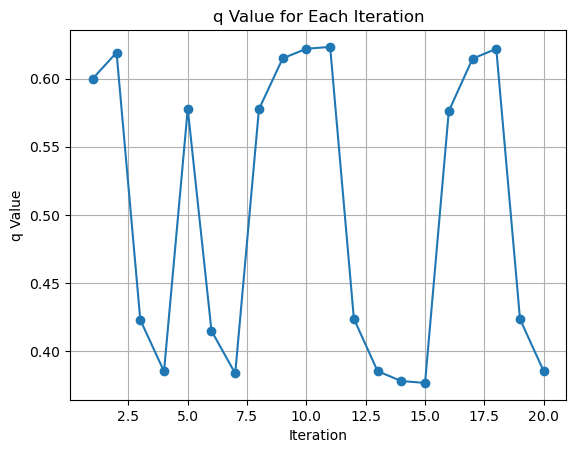

In [125]:
n = 20  # Number of periods
ini_sim = model.simulate(n)

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 